In [2]:
from pathlib import Path
from sklearn.model_selection import train_test_split
import shutil

# Define paths for training/validation and test datasets
train_val_dataset_path = "/teamspace/studios/this_studio/images_cropped_update_3"
test_dataset_path = "/teamspace/studios/this_studio/images_cropped_Gabriel_update_2"

# Define output paths for train, validation, and test splits
output_base_path = Path("/teamspace/studios/this_studio/dataset_classification_split_for_gabriel_test")
train_path = output_base_path / "train"
val_path = output_base_path / "val"
test_path = output_base_path / "test"

# Clear previous content if it exists
if output_base_path.exists():
    shutil.rmtree(output_base_path)
train_path.mkdir(parents=True, exist_ok=True)
val_path.mkdir(parents=True, exist_ok=True)
test_path.mkdir(parents=True, exist_ok=True)

# Gather all images from `images_cropped_update_3` for train/validation split
# Gather all images from `images_cropped_update_3` for train/validation split
all_train_val_images = []
for label in ["backhand", "forehand", "serve"]:
    class_path = Path(train_val_dataset_path) / label
    if class_path.exists():
        jpeg_images = list(class_path.rglob("*.jpeg"))
        jpg_images = list(class_path.rglob("*.jpg"))
        for img_path in jpeg_images + jpg_images:
            all_train_val_images.append((img_path, label))


# Split into train and validation sets (85% train, 15% val)
train_images, val_images = train_test_split(
    all_train_val_images, test_size=0.15, stratify=[label for _, label in all_train_val_images], random_state=42
)

# Copy train and validation images to respective folders
def copy_images(image_paths, target_folder):
    for img_path, label in image_paths:
        label_folder = target_folder / label
        label_folder.mkdir(parents=True, exist_ok=True)
        shutil.copy(img_path, label_folder / img_path.name)

copy_images(train_images, train_path)
copy_images(val_images, val_path)

# Copy images from `images_cropped_Gabriel_update_2` to the test folder
# Copy images from `images_cropped_Gabriel_update_2` to the test folder
for label in ["backhand", "forehand", "serve"]:
    class_path = Path(test_dataset_path) / label
    if class_path.exists():
        label_folder = test_path / label
        label_folder.mkdir(parents=True, exist_ok=True)
        jpeg_images = list(class_path.rglob("*.jpeg"))
        jpg_images = list(class_path.rglob("*.jpg"))
        for img_path in jpeg_images + jpg_images:
            shutil.copy(img_path, label_folder / img_path.name)


print("Data has been organized successfully with `images_cropped_Gabriel_update_2` as the test set.")


Data has been organized successfully with `images_cropped_Gabriel_update_2` as the test set.


In [3]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define transformations for data (for consistency)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(train_path, transform=transform)
val_dataset = datasets.ImageFolder(val_path, transform=transform)
test_dataset = datasets.ImageFolder(test_path, transform=transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [4]:
# Count the number of images in each dataset
train_count = len(train_dataset)
val_count = len(val_dataset)
test_count = len(test_dataset)

print(f"Training set: {train_count} images")
print(f"Validation set: {val_count} images")
print(f"Test set: {test_count} images")


Training set: 599 images
Validation set: 106 images
Test set: 605 images


In [5]:
import torch.nn as nn
from torchvision import models

# Load a pre-trained ResNet18 model
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 3)  # Adjust final layer for 3 classes

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Track metrics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        scheduler.step()
        train_accuracy = correct_train / total_train
        train_loss = running_loss / total_train

        # Validation loop
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        val_accuracy = correct_val / total_val
        val_loss = val_loss / total_val

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=80)


Epoch [1/80], Train Loss: 0.5593, Train Acc: 0.7730, Val Loss: 0.2114, Val Acc: 0.9245
Epoch [2/80], Train Loss: 0.1152, Train Acc: 0.9599, Val Loss: 1.1963, Val Acc: 0.6604
Epoch [3/80], Train Loss: 0.0463, Train Acc: 0.9766, Val Loss: 0.1143, Val Acc: 0.9528
Epoch [4/80], Train Loss: 0.0608, Train Acc: 0.9800, Val Loss: 0.4646, Val Acc: 0.8679
Epoch [5/80], Train Loss: 0.0461, Train Acc: 0.9900, Val Loss: 0.1683, Val Acc: 0.9434


Tested on 605 images.
Test Loss: 0.7106, Test Accuracy: 0.7620


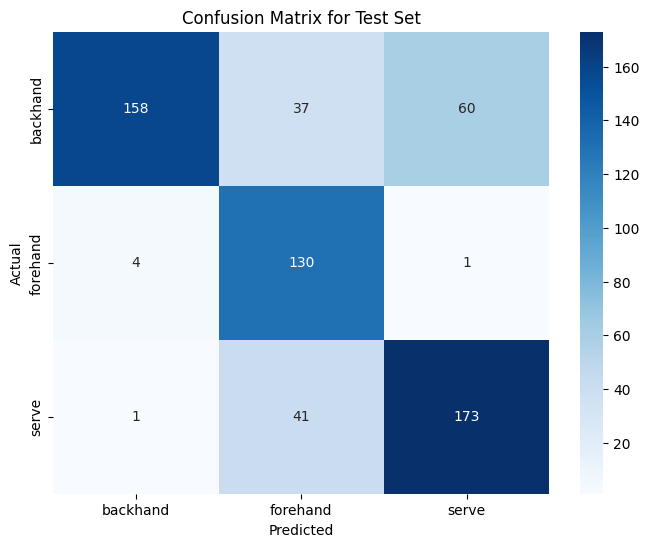


Classification Report:
              precision    recall  f1-score   support

    backhand       0.97      0.62      0.76       255
    forehand       0.62      0.96      0.76       135
       serve       0.74      0.80      0.77       215

    accuracy                           0.76       605
   macro avg       0.78      0.80      0.76       605
weighted avg       0.81      0.76      0.76       605



In [ ]:
# Testing function with additional evaluation metrics
def test_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_test += (predicted == labels).sum().item()
            total_test += labels.size(0)

            # Collect predictions and labels for further analysis
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_accuracy = correct_test / total_test
    test_loss = test_loss / total_test
    print(f"Tested on {total_test} images.")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    # Generate a confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_loader.dataset.classes, yticklabels=test_loader.dataset.classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix for Test Set")
    plt.show()

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=test_loader.dataset.classes))

# Test the model on Gabriel's dataset
test_model(model, test_loader, criterion)

In [ ]:
# # Imports
# import torch
# import torch.nn as nn
# from torch.utils.data import DataLoader
# from torchvision import datasets, transforms, models
# from sklearn.utils.class_weight import compute_class_weight
# import numpy as np

# # Device setup
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Data augmentation and normalization for training
# train_transform = transforms.Compose([
#     transforms.RandomResizedCrop(224),
#     transforms.RandomHorizontalFlip(),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
#     transforms.RandomRotation(15),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# # Normalization for validation and testing
# val_test_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# # Load datasets
# train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
# val_dataset = datasets.ImageFolder(val_path, transform=val_test_transform)
# test_dataset = datasets.ImageFolder(test_path, transform=val_test_transform)

# # Create data loaders
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# # Load a ResNet50 model
# model = models.resnet50(pretrained=True)
# model.fc = nn.Linear(model.fc.in_features, 3)  # Adjust final layer for 3 classes
# model = model.to(device)

# # Compute class weights to handle class imbalance
# labels = [label for _, label in train_dataset.samples]
# class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
# class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# # Define loss function with class weights
# criterion = nn.CrossEntropyLoss(weight=class_weights)

# # Use Adam optimizer with a lower learning rate
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# # Use ReduceLROnPlateau scheduler for dynamic learning rate adjustment
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# # Training function with early stopping
# def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30, patience=5):
#     best_val_loss = float('inf')
#     epochs_no_improve = 0

#     for epoch in range(num_epochs):
#         # Training phase
#         model.train()
#         running_loss = 0.0
#         correct_train = 0
#         total_train = 0

#         for inputs, labels in train_loader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#             # Track metrics
#             running_loss += loss.item() * inputs.size(0)
#             _, predicted = torch.max(outputs, 1)
#             correct_train += (predicted == labels).sum().item()
#             total_train += labels.size(0)

#         train_accuracy = correct_train / total_train
#         train_loss = running_loss / total_train

#         # Validation phase
#         model.eval()
#         val_loss = 0.0
#         correct_val = 0
#         total_val = 0

#         with torch.no_grad():
#             for inputs, labels in val_loader:
#                 inputs, labels = inputs.to(device), labels.to(device)
#                 outputs = model(inputs)
#                 loss = criterion(outputs, labels)
#                 val_loss += loss.item() * inputs.size(0)
#                 _, predicted = torch.max(outputs, 1)
#                 correct_val += (predicted == labels).sum().item()
#                 total_val += labels.size(0)

#         val_accuracy = correct_val / total_val
#         val_loss = val_loss / total_val

#         # Adjust learning rate based on validation loss
#         scheduler.step(val_loss)

#         print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

#         # Early stopping based on validation loss
#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             epochs_no_improve = 0
#             # Save the best model
#             torch.save(model.state_dict(), "best_model.pth")
#         else:
#             epochs_no_improve += 1

#         if epochs_no_improve >= patience:
#             print("Early stopping triggered.")
#             break

# # Train the model
# train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30)

# # Load the best model for testing
# model.load_state_dict(torch.load("best_model.pth"))

# # Testing function
# def test_model(model, test_loader, criterion):
#     model.eval()
#     test_loss = 0.0
#     correct_test = 0
#     total_test = 0

#     with torch.no_grad():
#         for inputs, labels in test_loader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             test_loss += loss.item() * inputs.size(0)
#             _, predicted = torch.max(outputs, 1)
#             correct_test += (predicted == labels).sum().item()
#             total_test += labels.size(0)

#     test_accuracy = correct_test / total_test
#     test_loss = test_loss / total_test
#     print(f"Tested on {total_test} images.")
#     print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# # Test the model on Gabriel's dataset
# test_model(model, test_loader, criterion)


In [ ]:
# # Testing function with additional evaluation metrics
# def test_model(model, test_loader, criterion):
#     model.eval()
#     test_loss = 0.0
#     correct_test = 0
#     total_test = 0
#     all_preds = []
#     all_labels = []

#     with torch.no_grad():
#         for inputs, labels in test_loader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             test_loss += loss.item() * inputs.size(0)
#             _, predicted = torch.max(outputs, 1)
#             correct_test += (predicted == labels).sum().item()
#             total_test += labels.size(0)

#             # Collect predictions and labels for further analysis
#             all_preds.extend(predicted.cpu().numpy())
#             all_labels.extend(labels.cpu().numpy())

#     test_accuracy = correct_test / total_test
#     test_loss = test_loss / total_test
#     print(f"Tested on {total_test} images.")
#     print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

#     # Generate a confusion matrix
#     cm = confusion_matrix(all_labels, all_preds)
#     plt.figure(figsize=(8, 6))
#     sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_loader.dataset.classes, yticklabels=test_loader.dataset.classes)
#     plt.xlabel("Predicted")
#     plt.ylabel("Actual")
#     plt.title("Confusion Matrix for Test Set")
#     plt.show()

#     # Print classification report
#     print("\nClassification Report:")
#     print(classification_report(all_labels, all_preds, target_names=test_loader.dataset.classes))

# # Test the model on Gabriel's dataset
# test_model(model, test_loader, criterion)


In [ ]:
# # Imports
# import torch
# import torch.nn as nn
# from torch.utils.data import DataLoader
# from torchvision import datasets, transforms, models
# from sklearn.utils.class_weight import compute_class_weight
# from sklearn.metrics import confusion_matrix, classification_report
# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Device setup
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Data augmentation for training
# train_transform = transforms.Compose([
#     transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
#     transforms.RandomHorizontalFlip(),
#     transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
#     transforms.RandomRotation(20),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# # Normalization for validation and testing
# val_test_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# # Load datasets
# train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
# val_dataset = datasets.ImageFolder(val_path, transform=val_test_transform)
# test_dataset = datasets.ImageFolder(test_path, transform=val_test_transform)

# # Create data loaders with batch size 16 for more gradient updates
# train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
# val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)
# test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

# # Load ResNet50 model and adjust for 3 classes
# model = models.resnet50(pretrained=True)
# model.fc = nn.Linear(model.fc.in_features, 3)  # Adjust final layer for 3 classes
# model = model.to(device)

# # Compute class weights to handle class imbalance
# labels = [label for _, label in train_dataset.samples]
# class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
# class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# # Define weighted cross-entropy loss
# criterion = nn.CrossEntropyLoss(weight=class_weights)

# # Use Adam optimizer with a lower learning rate
# optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)

# # Use ReduceLROnPlateau scheduler for dynamic learning rate adjustment
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# # Training function with early stopping
# def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30, patience=5):
#     best_val_loss = float('inf')
#     epochs_no_improve = 0

#     for epoch in range(num_epochs):
#         # Training phase
#         model.train()
#         running_loss = 0.0
#         correct_train = 0
#         total_train = 0

#         for inputs, labels in train_loader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#             # Track metrics
#             running_loss += loss.item() * inputs.size(0)
#             _, predicted = torch.max(outputs, 1)
#             correct_train += (predicted == labels).sum().item()
#             total_train += labels.size(0)

#         train_accuracy = correct_train / total_train
#         train_loss = running_loss / total_train

#         # Validation phase
#         model.eval()
#         val_loss = 0.0
#         correct_val = 0
#         total_val = 0

#         with torch.no_grad():
#             for inputs, labels in val_loader:
#                 inputs, labels = inputs.to(device), labels.to(device)
#                 outputs = model(inputs)
#                 loss = criterion(outputs, labels)
#                 val_loss += loss.item() * inputs.size(0)
#                 _, predicted = torch.max(outputs, 1)
#                 correct_val += (predicted == labels).sum().item()
#                 total_val += labels.size(0)

#         val_accuracy = correct_val / total_val
#         val_loss = val_loss / total_val

#         # Adjust learning rate based on validation loss
#         scheduler.step(val_loss)

#         print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

#         # Early stopping based on validation loss
#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             epochs_no_improve = 0
#             # Save the best model
#             torch.save(model.state_dict(), "best_model.pth")
#         else:
#             epochs_no_improve += 1

#         if epochs_no_improve >= patience:
#             print("Early stopping triggered.")
#             break

# # Train the model
# train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30)

# # Load the best model for testing
# model.load_state_dict(torch.load("best_model.pth"))

# # Testing function with additional evaluation metrics
# def test_model(model, test_loader, criterion):
#     model.eval()
#     test_loss = 0.0
#     correct_test = 0
#     total_test = 0
#     all_preds = []
#     all_labels = []

#     with torch.no_grad():
#         for inputs, labels in test_loader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             test_loss += loss.item()


In [ ]:
# # Imports
# import torch
# import torch.nn as nn
# from torch.utils.data import DataLoader
# from torchvision import datasets, transforms, models
# from sklearn.utils.class_weight import compute_class_weight
# from sklearn.metrics import confusion_matrix, classification_report
# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Device setup
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Data augmentation for training
# train_transform = transforms.Compose([
#     transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
#     transforms.RandomHorizontalFlip(),
#     transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
#     transforms.RandomRotation(20),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# # Normalization for validation and testing
# val_test_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# # Load datasets
# train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
# val_dataset = datasets.ImageFolder(val_path, transform=val_test_transform)
# test_dataset = datasets.ImageFolder(test_path, transform=val_test_transform)

# # Create data loaders with batch size 16 for more gradient updates
# train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
# val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)
# test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

# # Load ResNet34 model and adjust for 3 classes
# model = models.resnet34(pretrained=True)
# model.fc = nn.Linear(model.fc.in_features, 3)  # Adjust final layer for 3 classes
# model = model.to(device)


# # Compute class weights to handle class imbalance
# labels = [label for _, label in train_dataset.samples]
# class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
# class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# # Define weighted cross-entropy loss
# criterion = nn.CrossEntropyLoss(weight=class_weights)

# # Use Adam optimizer with a lower learning rate
# optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)

# # Use ReduceLROnPlateau scheduler for dynamic learning rate adjustment
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# # Training function with early stopping
# def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30, patience=5):
#     best_val_loss = float('inf')
#     epochs_no_improve = 0

#     for epoch in range(num_epochs):
#         # Training phase
#         model.train()
#         running_loss = 0.0
#         correct_train = 0
#         total_train = 0

#         for inputs, labels in train_loader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#             # Track metrics
#             running_loss += loss.item() * inputs.size(0)
#             _, predicted = torch.max(outputs, 1)
#             correct_train += (predicted == labels).sum().item()
#             total_train += labels.size(0)

#         train_accuracy = correct_train / total_train
#         train_loss = running_loss / total_train

#         # Validation phase
#         model.eval()
#         val_loss = 0.0
#         correct_val = 0
#         total_val = 0

#         with torch.no_grad():
#             for inputs, labels in val_loader:
#                 inputs, labels = inputs.to(device), labels.to(device)
#                 outputs = model(inputs)
#                 loss = criterion(outputs, labels)
#                 val_loss += loss.item() * inputs.size(0)
#                 _, predicted = torch.max(outputs, 1)
#                 correct_val += (predicted == labels).sum().item()
#                 total_val += labels.size(0)

#         val_accuracy = correct_val / total_val
#         val_loss = val_loss / total_val

#         # Adjust learning rate based on validation loss
#         scheduler.step(val_loss)

#         print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

#         # Early stopping based on validation loss
#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             epochs_no_improve = 0
#             # Save the best model
#             torch.save(model.state_dict(), "best_model.pth")
#         else:
#             epochs_no_improve += 1

#         if epochs_no_improve >= patience:
#             print("Early stopping triggered.")
#             break

# # Train the model
# train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30)

# # Load the best model for testing
# model.load_state_dict(torch.load("best_model.pth"))

# # Testing function with additional evaluation metrics
# def test_model(model, test_loader, criterion):
#     model.eval()
#     test_loss = 0.0
#     correct_test = 0
#     total_test = 0
#     all_preds = []
#     all_labels = []

#     with torch.no_grad():
#         for inputs, labels in test_loader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             test_loss += loss.item()


In [ ]:
# # Imports
# import torch
# import torch.nn as nn
# from torch.utils.data import DataLoader, WeightedRandomSampler
# from torchvision import datasets, transforms, models
# from sklearn.utils.class_weight import compute_class_weight
# from sklearn.metrics import confusion_matrix, classification_report
# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Device setup
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Data augmentation for training
# train_transform = transforms.Compose([
#     transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
#     transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
#     transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
#     transforms.RandomRotation(20),
#     transforms.GaussianBlur(kernel_size=(3, 3)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# # Normalization for validation and testing
# val_test_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# # Load datasets
# train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
# val_dataset = datasets.ImageFolder(val_path, transform=val_test_transform)
# test_dataset = datasets.ImageFolder(test_path, transform=val_test_transform)

# # Sampling strategy for handling class imbalance
# labels = [label for _, label in train_dataset.samples]
# class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
# sample_weights = [class_weights[label] for label in labels]
# sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

# # Create data loaders
# train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler, num_workers=4)
# val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)
# test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

# # Load ResNet34 model and adjust for 3 classes
# model = models.resnet34(pretrained=True)
# model.fc = nn.Linear(model.fc.in_features, 3)  # Adjust final layer for 3 classes
# model = model.to(device)

# # Define Focal Loss as an alternative to CrossEntropyLoss
# class FocalLoss(nn.Module):
#     def __init__(self, gamma=2, alpha=torch.tensor(class_weights, dtype=torch.float).to(device), reduction='mean'):
#         super(FocalLoss, self).__init__()
#         self.gamma = gamma
#         self.alpha = alpha
#         self.reduction = reduction

#     def forward(self, inputs, targets):
#         ce_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
#         pt = torch.exp(-ce_loss)
#         focal_loss = (self.alpha[targets] * (1 - pt) ** self.gamma * ce_loss)
#         return focal_loss.mean() if self.reduction == 'mean' else focal_loss.sum()

# # Use FocalLoss (uncomment the next line to use FocalLoss)
# # criterion = FocalLoss(gamma=2)

# # Use weighted cross-entropy loss (default)
# criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float).to(device))

# # Adam optimizer with a lower learning rate
# optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)

# # Scheduler for dynamic learning rate adjustment
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# # Training function with early stopping
# def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30, patience=5):
#     best_val_loss = float('inf')
#     epochs_no_improve = 0

#     for epoch in range(num_epochs):
#         # Training phase
#         model.train()
#         running_loss = 0.0
#         correct_train = 0
#         total_train = 0

#         for inputs, labels in train_loader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#             # Track metrics
#             running_loss += loss.item() * inputs.size(0)
#             _, predicted = torch.max(outputs, 1)
#             correct_train += (predicted == labels).sum().item()
#             total_train += labels.size(0)

#         train_accuracy = correct_train / total_train
#         train_loss = running_loss / total_train

#         # Validation phase
#         model.eval()
#         val_loss = 0.0
#         correct_val = 0
#         total_val = 0

#         with torch.no_grad():
#             for inputs, labels in val_loader:
#                 inputs, labels = inputs.to(device), labels.to(device)
#                 outputs = model(inputs)
#                 loss = criterion(outputs, labels)
#                 val_loss += loss.item() * inputs.size(0)
#                 _, predicted = torch.max(outputs, 1)
#                 correct_val += (predicted == labels).sum().item()
#                 total_val += labels.size(0)

#         val_accuracy = correct_val / total_val
#         val_loss = val_loss / total_val

#         # Adjust learning rate based on validation loss
#         scheduler.step(val_loss)

#         print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

#         # Early stopping based on validation loss
#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             epochs_no_improve = 0
#             # Save the best model
#             torch.save(model.state_dict(), "best_model.pth")
#         else:
#             epochs_no_improve += 1

#         if epochs_no_improve >= patience:
#             print("Early stopping triggered.")
#             break

# # Train the model
# train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30)

# # Load the best model for testing
# model.load_state_dict(torch.load("best_model.pth"))

# # Testing function with additional evaluation metrics
# def test_model(model, test_loader, criterion):
#     model.eval()
#     test_loss = 0.0
#     correct_test = 0
#     total_test = 0
#     all_preds = []
#     all_labels = []

#     with torch.no_grad():
#         for inputs, labels in test_loader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             test_loss += loss.item() * inputs.size(0)
#             _, predicted = torch.max(outputs, 1)
#             correct_test += (predicted == labels).sum().item()
#             total_test += labels.size(0)

#             # Collect predictions and labels for further analysis
#             all_preds.extend(predicted.cpu().numpy())
#             all_labels.extend(labels.cpu().numpy())

#     test_accuracy = correct_test / total_test
#     test_loss = test_loss / total_test
#     print(f"Tested on {total_test} images.")
#     print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

#     # Generate a confusion matrix
#     cm = confusion_matrix(all_labels, all_preds)
#     plt.figure(figsize=(8, 6))
#     sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_loader.dataset.classes, yticklabels=test_loader.dataset.classes)
#     plt.xlabel("Predicted")
#     plt.ylabel("Actual")
#     plt.title("Confusion Matrix for Test Set")
#     plt.show()

#     # Print classification report
#     print("\nClassification Report:")
#     print(classification_report(all_labels, all_preds, target_names=test_loader.dataset.classes))

# # Test the model on the test set
# test_model(model, test_loader, criterion)



In [ ]:
# # Testing function with additional evaluation metrics
# def test_model(model, test_loader, criterion):
#     model.eval()
#     test_loss = 0.0
#     correct_test = 0
#     total_test = 0
#     all_preds = []
#     all_labels = []

#     with torch.no_grad():
#         for inputs, labels in test_loader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             test_loss += loss.item() * inputs.size(0)
#             _, predicted = torch.max(outputs, 1)
#             correct_test += (predicted == labels).sum().item()
#             total_test += labels.size(0)

#             # Collect predictions and labels for further analysis
#             all_preds.extend(predicted.cpu().numpy())
#             all_labels.extend(labels.cpu().numpy())

#     test_accuracy = correct_test / total_test
#     test_loss = test_loss / total_test
#     print(f"Tested on {total_test} images.")
#     print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

#     # Generate a confusion matrix
#     cm = confusion_matrix(all_labels, all_preds)
#     plt.figure(figsize=(8, 6))
#     sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_loader.dataset.classes, yticklabels=test_loader.dataset.classes)
#     plt.xlabel("Predicted")
#     plt.ylabel("Actual")
#     plt.title("Confusion Matrix for Test Set")
#     plt.show()

#     # Print classification report
#     print("\nClassification Report:")
#     print(classification_report(all_labels, all_preds, target_names=test_loader.dataset.classes))

# # Test the model on Gabriel's dataset
# test_model(model, test_loader, criterion)

In [ ]:
# import random
# from PIL import Image
# import matplotlib.pyplot as plt
# import torch

# # Define transformations for display (already applied to `test_loader`)
# test_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# # Ensure the test dataset and loader are defined
# test_dir = "/teamspace/studios/this_studio/images_cropped_Gabriel_update_2"
# test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)
# test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

# # Select 10 random images from the test set
# sample_images = random.sample(list(test_loader), k=10)

# # Plot the sample images with model predictions and true labels
# model.eval()
# plt.figure(figsize=(15, 10))
# for i, (inputs, labels) in enumerate(sample_images, start=1):
#     inputs = inputs.to(device)
#     labels = labels.to(device)

#     # Get model predictions
#     with torch.no_grad():
#         outputs = model(inputs)
#         _, predicted = torch.max(outputs, 1)
    
#     # Convert image tensor to a displayable format
#     img = inputs.cpu().squeeze(0).permute(1, 2, 0).numpy()
#     img = (img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]).clip(0, 1)  # Denormalize for display

#     # Display image, prediction, and actual label
#     plt.subplot(2, 5, i)
#     plt.imshow(img)
#     plt.title(f"Predicted: {test_dataset.classes[predicted.item()]}\nActual: {test_dataset.classes[labels.item()]}")
#     plt.axis("off")

# plt.tight_layout()
# plt.show()
